In [1]:
import os
import re
import sys
from pathlib import Path

import h5py
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import skimage
from skimage import io
from tqdm.notebook import tqdm, trange
import seaborn as sns
from matplotlib.colors import LogNorm
from matplotlib.patches import Patch
import matplotlib 

sc.settings.verbosity = 3


In [2]:
p_dir = (Path().cwd().parents[0]).absolute()
data_dir = p_dir / "data"

In [3]:
%load_ext autoreload
%autoreload 2

module_path = str(p_dir / "src")

if module_path not in sys.path:
    sys.path.append(module_path)

import utils as my_utils

In [4]:
donors = [
    "LN Donor A",
    "LN Donor E",
    "INT Donor B",
    "INT Donor E",
    "TS Donor A",
    "TS Donor E",
]


# Read Data

In [5]:
from skimage import exposure 

def contrast_streching(img):
    p2, p98 = np.percentile(img, (0.5, 99.5))
    img = exposure.rescale_intensity(img, in_range=(p2, p98), out_range=(0, 255)).astype(np.uint8)
    return img

In [6]:
# Read single-cell data
adata_path = data_dir / "metadata" / f"combined_semi_final.h5ad"
adata = sc.read_h5ad(adata_path)

In [7]:
marker = 'COL1'
imgs_col = []

# Read COL1 images
for donor in donors:
    path = p_dir / "data" / "whole_stitched"/ donor / f"{marker}.tif"
    
    img = skimage.io.imread(path)

    img_col= contrast_streching(img)
    if donor == 'INT Donor B':
        img_col = img_col[:5000, :]
    imgs_col.append(img_col)
    

In [8]:
rename_dict = {'Activated B':'B-cells',  'B-cells MZ':'B-cells', 'CD38+': 'Stroma', 
               'Stroma Vimentin+': 'Stroma'
              }
# rename_dict = {'Activated B':'B-cells',  'B-cells MZ':'B-cells', 
#                'Stroma Vimentin+': 'Stroma'
#               }

# Rename a cluster
adata.obs["cluster"] = adata.obs["Phenotype"].map(lambda x: rename_dict.get(x, x)).astype('category')


In [9]:
np.random.seed(2)
rename_dict = {'Stroma': 'Other', 'FDC':'Other', 'myeloid-derived cells': 'Other',  'B-cells': 'Other', 'DZ B-cells': 'Other', 'LZ B-cells':'Other'}

adata.obs['cluster_new'] = adata.obs['cluster'].map(lambda x: rename_dict.get(x, x)).astype('category')
adata.uns['cluster_new_colors'] = np.random.choice(adata.uns['Phenotype_colors'], len(np.unique(adata.obs['cluster_new'])), replace=False, )
adata.uns['cluster_new_colors'][-3] = '#808080'

In [10]:
np.unique(adata.obs.cluster_new)

array(['Cytotoxic T-cells', 'Exhausted T-cells', 'Helper T-cells',
       'Other', 'TFH', 'Treg'], dtype=object)

In [11]:
# Get adata 
phenotype_name = 'cluster_new'

sc.tl.dendrogram(adata, groupby=phenotype_name)

cluster_label_order = adata.uns[f'dendrogram_{phenotype_name}']['categories_ordered']

# Define colormap
colors = adata.uns[f"{phenotype_name}_colors"]
labels = adata.obs[phenotype_name].cat.categories.tolist()

colors_rgb = []
for color in colors:
    colors_rgb.append(matplotlib.colors.hex2color(color))
colors_rgb = np.array(colors_rgb) * 255
colors_rgb = colors_rgb.astype(np.uint8)
colors_rgb_dict = {k:v for k,v in zip(labels, colors_rgb)}

    using data matrix X directly
Storing dendrogram info using `.uns['dendrogram_cluster_new']`


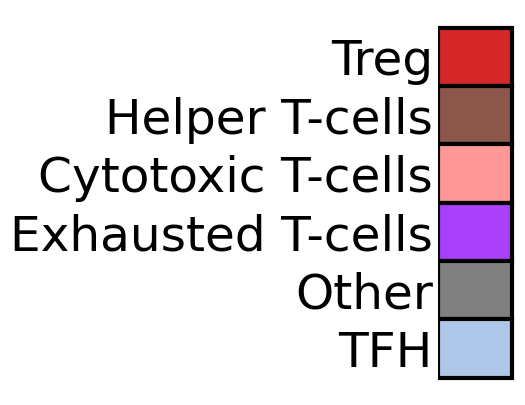

In [12]:
c=np.array([colors_rgb_dict[i] for i in cluster_label_order])

# legend
fig, ax = plt.subplots(figsize=(1,5))
ax.barh(y=range(len(colors_rgb_dict.values())), 
        color=c/255,
        width=1, 
        height=1,
        edgecolor='k',
        linewidth=3,
       )
_ = plt.yticks(range(len(colors_rgb_dict.values())), cluster_label_order, rotation=0, size=35)
_ = plt.xticks([])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.tick_params(axis=u'both', which=u'both',length=0)
# ax.yaxis.tick_right()
ax.invert_yaxis()
ax.grid(False)


# Col analysis

In [13]:
import numpy as np
from scipy.ndimage import distance_transform_edt

def expand_labels(label_image, distance=1):
    distances, nearest_label_coords = distance_transform_edt(
        label_image == 0, return_indices=True
    )
    labels_out = np.zeros_like(label_image)
    dilate_mask = distances <= distance
    # build the coordinates to find nearest labels,
    # in contrast to [1] this implementation supports label arrays
    # of any dimension
    masked_nearest_label_coords = [
        dimension_indices[dilate_mask]
        for dimension_indices in nearest_label_coords
    ]
    nearest_labels = label_image[tuple(masked_nearest_label_coords)]
    labels_out[dilate_mask] = nearest_labels
    return labels_out

In [14]:
from skimage.measure import block_reduce
from skimage import filters 

def mean_block(img, size):
    reduced = block_reduce(img_col, block_size=(size, size), func=np.mean)
    # reduced = filters.gaussian(reduced, sigma=1)
    img_mean = np.repeat(reduced, size, axis=0)
    img_mean = np.repeat(img_mean, size, axis=1)
    img_mean[:img.shape[0], :img.shape[1]]
    img_mean = filters.gaussian(img_mean, sigma=10)
    return reduced, img_mean 

In [15]:
from skimage import morphology
from matplotlib.colors import LinearSegmentedColormap, ListedColormap

def create_gradient(mask, size=100, n=5):
    mask = morphology.remove_small_objects(mask, min_size=10000)
    mask_grad = (mask*1).astype(np.uint8)    
    for i in range(2, n+2):
        mask_expanded = expand_labels(mask_grad, distance=size)
        mask_expanded = np.where(mask_expanded>0, mask_expanded+1, 0) 
        mask_grad = np.where(mask_grad>0, mask_grad, mask_expanded) 
    return mask_grad

In [16]:
from matplotlib.colors import LinearSegmentedColormap, ListedColormap

# get colormap
ncolors = 100
color_array = plt.get_cmap('Wistia')(range(ncolors))

# change alpha values
color_array[:,-1] = np.zeros(ncolors)
color_array[ncolors//4:, -1] = np.linspace(0.0,1.0, ncolors-ncolors//4)

# create a colormap object
mycmap_y= LinearSegmentedColormap.from_list(name='mycmap_y', colors=color_array)


(5000, 4000)


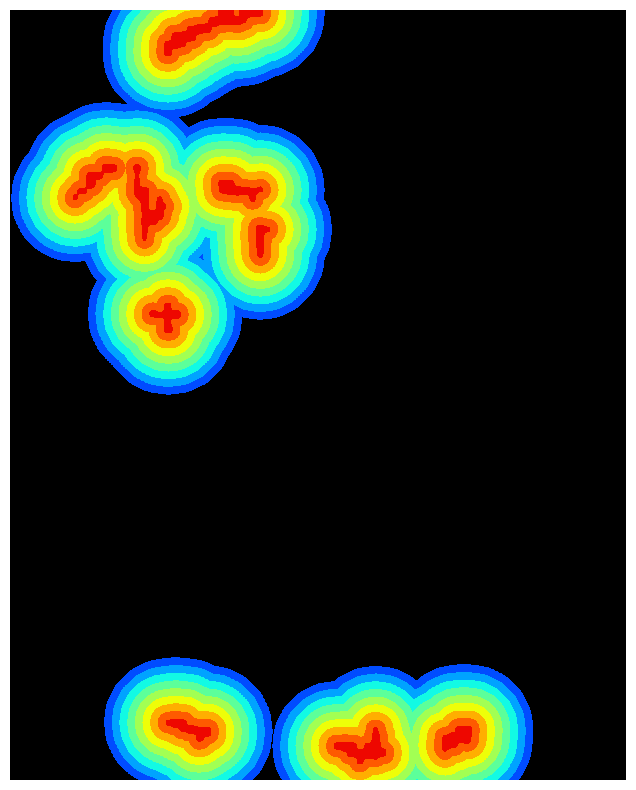

(2000, 9000)


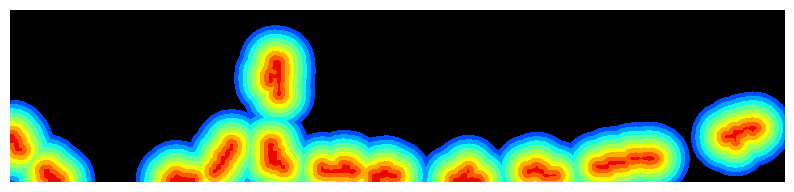

(5000, 4000)


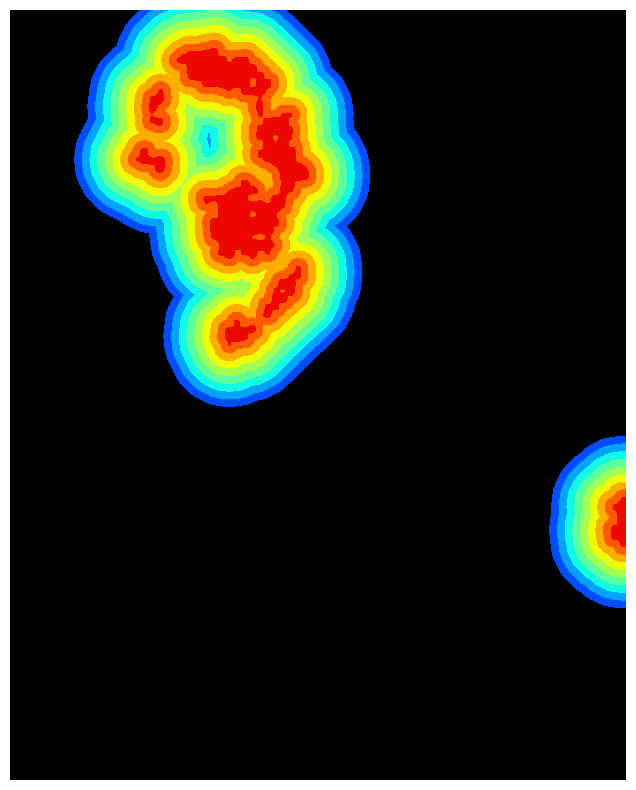

(5000, 5000)


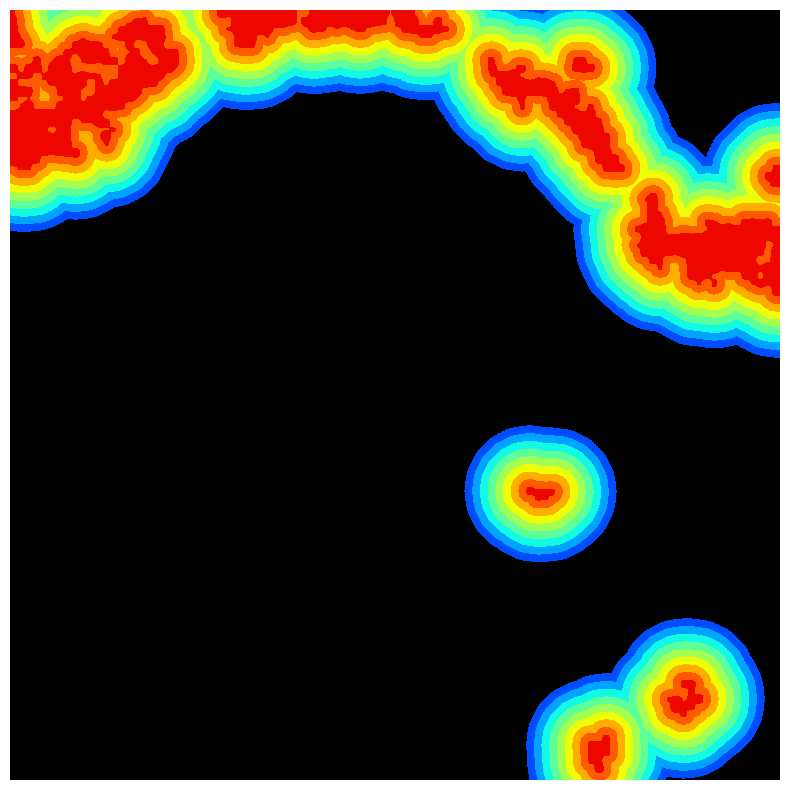

(2000, 7000)


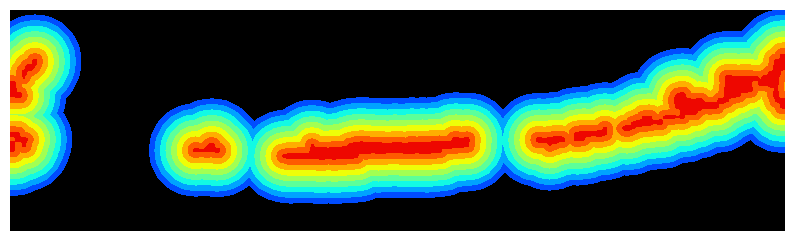

(6000, 3000)


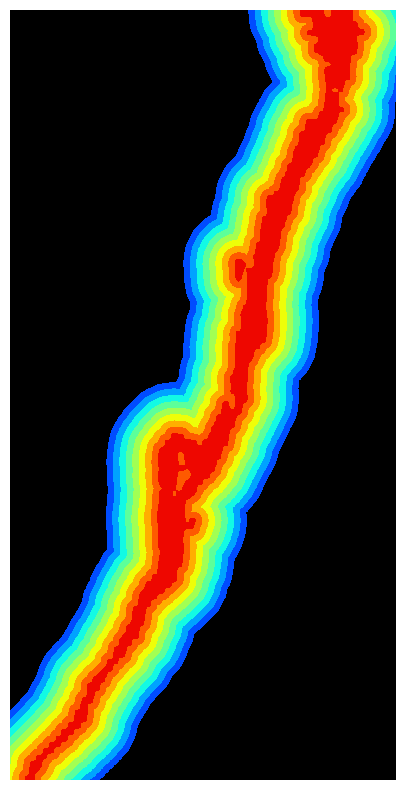

In [17]:
size = 50
thresh = 60
masks_grad = []
n = 8
pad_size = 50

# get colormap
ncolors = n+1
color_array = plt.get_cmap('jet_r')(np.linspace(0.1, 0.8, ncolors))

# change alpha values
color_array = np.vstack([np.array([0,0,0,1]), color_array])

# create a colormap object
mycmap= LinearSegmentedColormap.from_list(name='mycmap', colors=color_array)

for i in range(len(donors)):
    # Read COL image and follicle mask
    img_col = imgs_col[i]
    print(img_col.shape)
    
    # Get average marker image
    _, img_mean = mean_block(img_col, size)
    img_mean_pos = img_mean > thresh
    
    # Get Gradient image
    mask_grad = create_gradient(img_mean_pos, size=pad_size, n=n)
    masks_grad.append(mask_grad)
    
    # fig, ax = plt.subplots(figsize=(10,10))
    # ax.imshow(img_mean)
    # ax.axis('off')
    
    fig, ax = plt.subplots(figsize=(10,10))
    ax.imshow(mask_grad, cmap=mycmap, interpolation='none')
    ax.axis('off')
    
    plt.show()


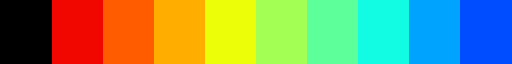

In [18]:
# create a colormap object
ListedColormap(colors=color_array)

In [19]:
dfs_pheno = []
for i in range(len(donors)):
    adata_donor = adata[adata.obs.Dataset == donors[i]]
    X = np.array(adata_donor.obsm['spatial'])[:,[1,0]].astype(int)
    df_pheno = pd.DataFrame(adata_donor.obs['cluster_new'])
    mask_grad = masks_grad[i]
    zones = mask_grad[X[:,0], X[:,1]]
    df_pheno['Zone'] = zones
    df_pheno['Donor'] = donors[i]
    dfs_pheno.append(df_pheno)

In [20]:
df_pheno = pd.concat(dfs_pheno)

In [21]:
df_count = df_pheno.groupby(['Donor', 'Zone'])[['cluster_new']].value_counts()
df_count = df_count.reset_index()
df_count.columns = ['Donor', 'Zone', 'cluster', 'Count']
df_count = df_count[df_count.Zone != 0]

In [22]:
df_count.head()

Donor  Zone            cluster  Count
6   INT Donor B     1              Other   2926
7   INT Donor B     1                TFH    138
8   INT Donor B     1     Helper T-cells    130
9   INT Donor B     1  Cytotoxic T-cells    111
10  INT Donor B     1               Treg    101

In [23]:
df_pivot = df_count.pivot(index=['Zone', 'Donor'], columns='cluster', values='Count') + 1
df_pivot = df_pivot.div(df_pivot.sum(axis=1), axis=0)

In [24]:
df_pivot

cluster           Cytotoxic T-cells  Exhausted T-cells  Helper T-cells  \
Zone Donor                                                               
1    INT Donor B           0.032816           0.000586        0.038383   
     INT Donor E           0.041780           0.000993        0.020724   
     LN Donor A            0.004700           0.001175        0.001175   
     LN Donor E            0.016649           0.000537        0.015038   
     TS Donor A            0.018668           0.000225        0.019343   
     TS Donor E            0.004257           0.000170        0.005278   
2    INT Donor B           0.058593           0.001226        0.043638   
     INT Donor E           0.066260           0.001610        0.032670   
     LN Donor A            0.023585           0.000524        0.014151   
     LN Donor E            0.096209           0.000237        0.048104   
     TS Donor A            0.109753           0.000231        0.141227   
     TS Donor E            0.070439           0.000116        0.140063   
3    INT Donor B           0.056072           0.001469        0.047992   
     INT Donor E           0.069199           0.001085        0.035821   
     LN Donor A            0.035700           0.000397        0.021420   
     LN Donor E            0.086549           0.000318        0.041131   
     TS Donor A            0.151699           0.000618        0.236972   
     TS Donor E            0.129029           0.000537        0.360120   
4    INT Donor B           0.059395           0.002700        0.042927   
     INT Donor E           0.088948           0.002255        0.040880   
     LN Donor A            0.036787           0.001012        0.017212   
     LN Donor E            0.081570           0.000238        0.041855   
     TS Donor A            0.121128           0.000671        0.288194   
     TS Donor E            0.144240           0.000312        0.411073   
5    INT Donor B           0.052375           0.000914        0.044458   
     INT Donor E           0.081760           0.005083        0.035579   
     LN Donor A            0.056534           0.000927        0.033673   
     LN Donor E            0.092029           0.000202        0.052632   
     TS Donor A            0.115595           0.001577        0.297709   
     TS Donor E            0.140162           0.000527        0.409632   
6    INT Donor B           0.062815           0.001680        0.039973   
     INT Donor E           0.062285           0.007786        0.032789   
     LN Donor A            0.077278           0.000288        0.038351   
     LN Donor E            0.108673           0.000375        0.067042   
     TS Donor A            0.112711           0.001229        0.275808   
     TS Donor E            0.131593           0.000539        0.384856   
7    INT Donor B           0.073135           0.002172        0.039102   
     INT Donor E           0.064278           0.010303        0.036906   
     LN Donor A            0.075873           0.000788        0.053557   
     LN Donor E            0.119513           0.000553        0.084563   
     TS Donor A            0.092522           0.001644        0.290981   
     TS Donor E            0.119254           0.000562        0.347533   
8    INT Donor B           0.087174           0.004224        0.040707   
     INT Donor E           0.069812           0.014199        0.044372   
     LN Donor A            0.098039           0.000774        0.072755   
     LN Donor E            0.125650           0.000186        0.106891   
     TS Donor A            0.080754           0.000884        0.252963   
     TS Donor E            0.098777           0.000346        0.317447   
9    INT Donor B           0.089530           0.003700        0.050684   
     INT Donor E           0.065236           0.021890        0.037257   
     LN Donor A            0.124874           0.000504        0.111531   
     LN Donor E            0.139403           0.000190        0.138454   
    

Other


C:\Users\thu71\AppData\Local\Temp\ipykernel_5540\840424085.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset.loc[:, 'Tissue'] = df_subset['Donor'].str[:-2]


TFH


C:\Users\thu71\AppData\Local\Temp\ipykernel_5540\840424085.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset.loc[:, 'Tissue'] = df_subset['Donor'].str[:-2]


Helper T-cells


C:\Users\thu71\AppData\Local\Temp\ipykernel_5540\840424085.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset.loc[:, 'Tissue'] = df_subset['Donor'].str[:-2]


Cytotoxic T-cells


C:\Users\thu71\AppData\Local\Temp\ipykernel_5540\840424085.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset.loc[:, 'Tissue'] = df_subset['Donor'].str[:-2]


Treg


C:\Users\thu71\AppData\Local\Temp\ipykernel_5540\840424085.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset.loc[:, 'Tissue'] = df_subset['Donor'].str[:-2]


Exhausted T-cells


C:\Users\thu71\AppData\Local\Temp\ipykernel_5540\840424085.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset.loc[:, 'Tissue'] = df_subset['Donor'].str[:-2]


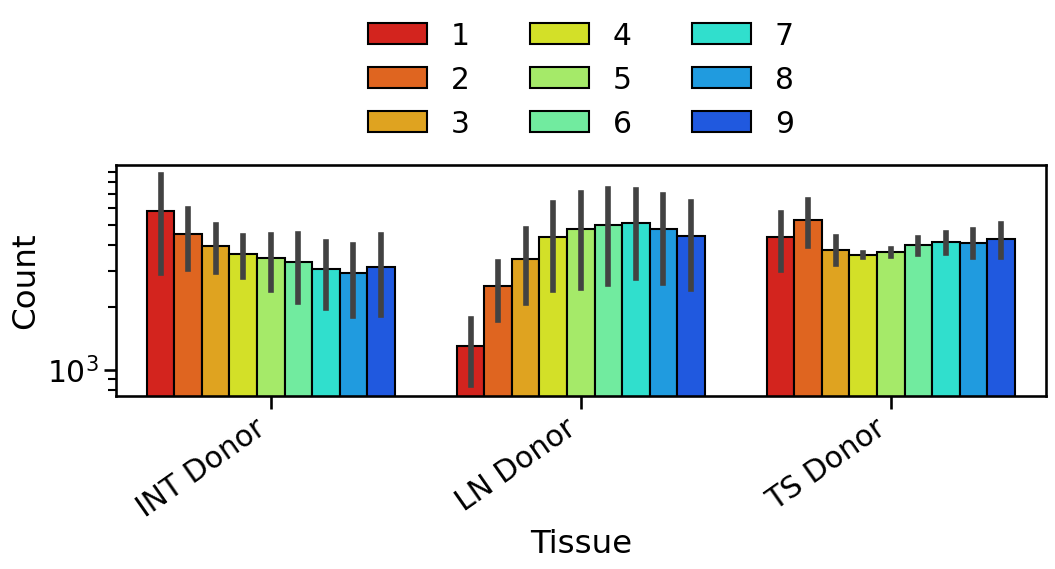

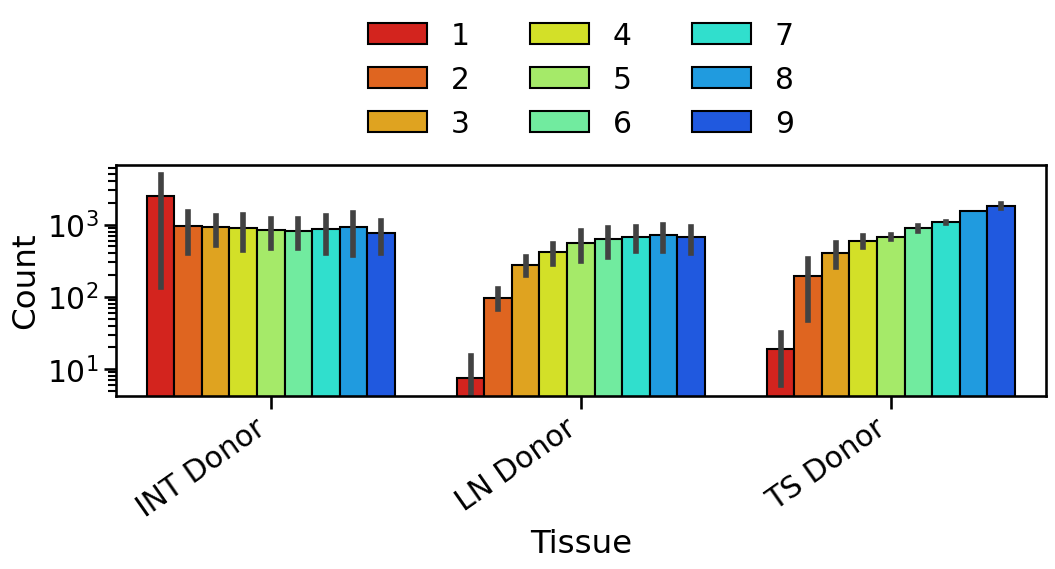

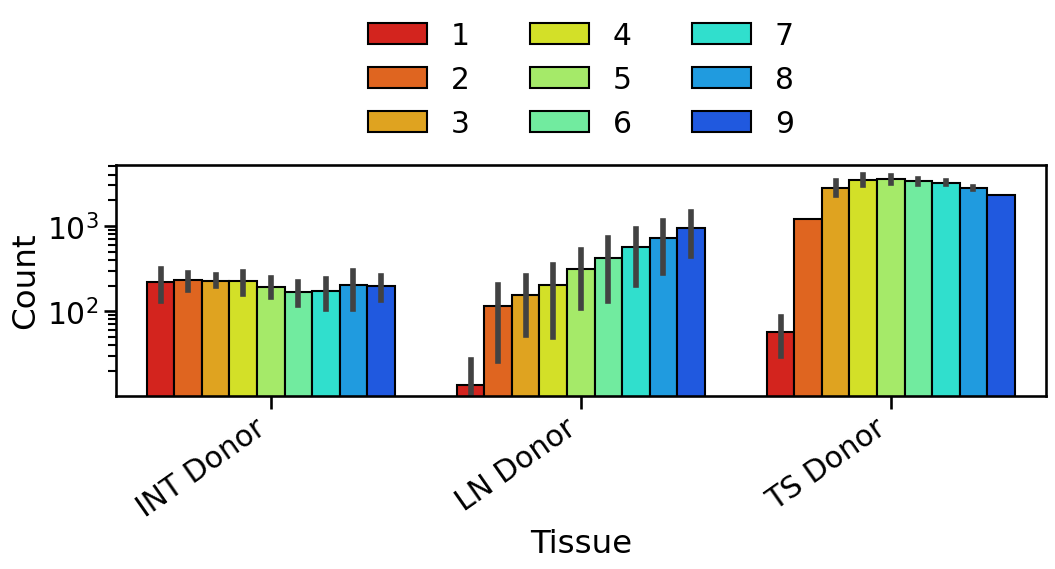

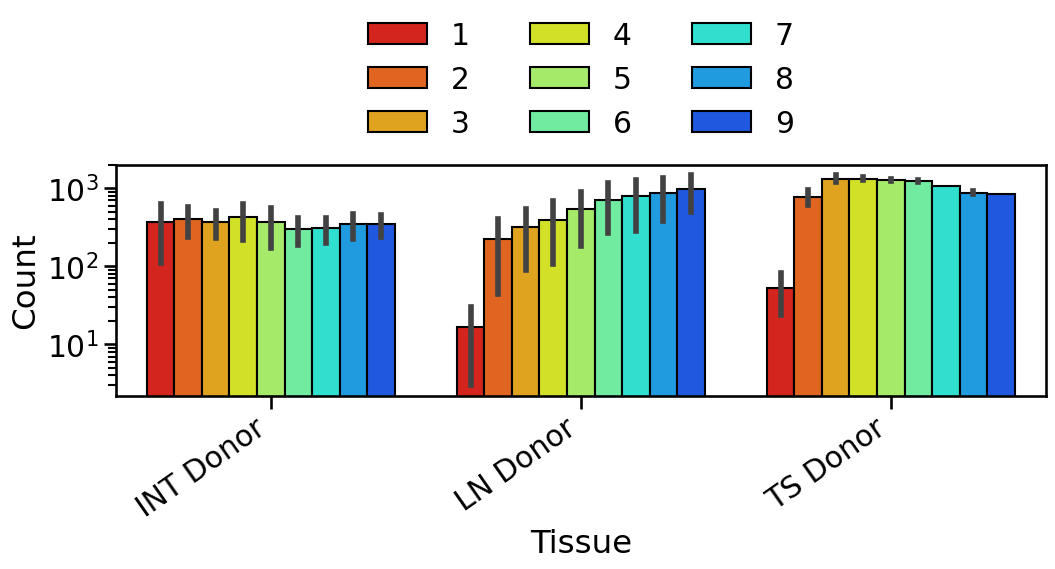

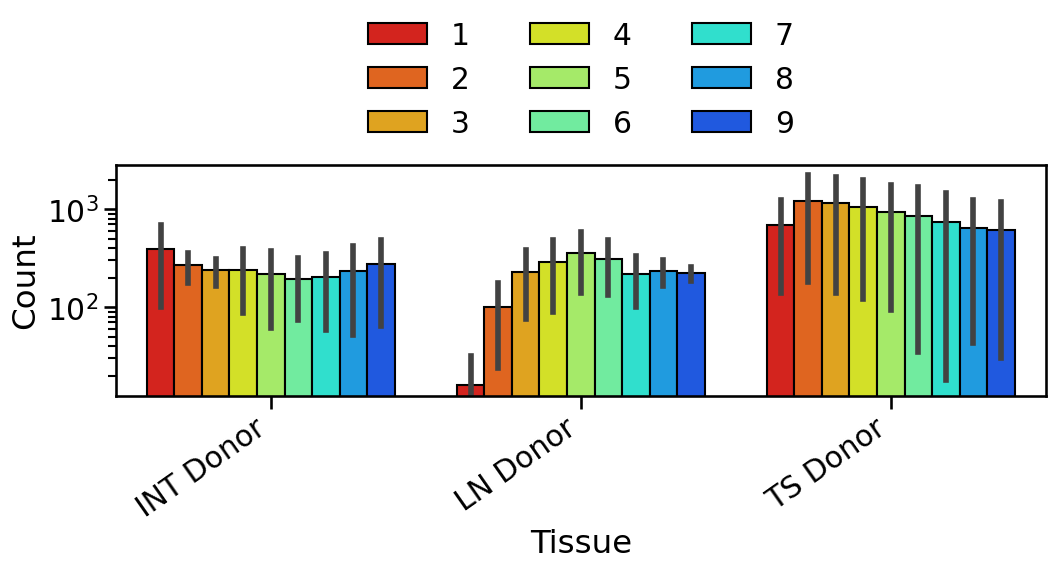

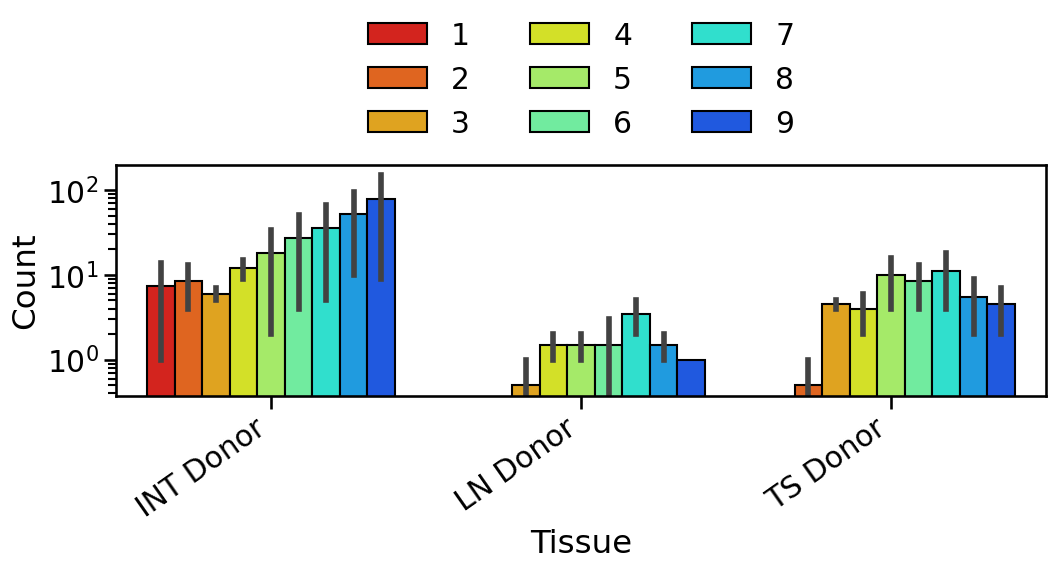

In [25]:
for c in df_count.cluster.unique():
    print(c)
    df_subset = df_count[df_count.cluster == c]
    df_subset.loc[:, 'Tissue'] = df_subset['Donor'].str[:-2]
    with sns.plotting_context('talk', font_scale=1.3):
        fig,ax = plt.subplots(figsize=(12,3))
        g = sns.barplot(data=df_subset, x="Tissue", y="Count", hue="Zone", ax=ax, palette=color_array[1:],
                   edgecolor='k')
        sns.move_legend(ax, "lower center", bbox_to_anchor=(.5, 1), ncol=3, title=None, frameon=False)
        g.set_yscale("log")
        plt.xticks(rotation=35, ha='right')

# Plot

In [26]:
# Plot clustered cell within each mask
import matplotlib 
from PIL import Image
from skimage import measure 

def create_clustered_cell(mask, label2cell, my_cmap, **kwargs):
    img = np.zeros((mask.shape[0], mask.shape[1],3), dtype=np.uint8)

    # for i, cells in tqdm(label2cell.items(), total=len(label2cell), leave=False):
    for i, cells in label2cell.items():
        rows, cols = np.where(np.isin(mask, cells))
        img[rows, cols, :] = my_cmap[int(i)]
    return img


def get_img_size(roi_dict, size=1000):
    row_max = 0
    col_max = 0
    for k, v in roi_dict.items():
        row_max = max(row_max, v[0])
        col_max = max(col_max, v[1])
    return row_max + size, col_max + size

# Read mask image
def get_masks(mask_folder):
    """
    Function to get all mask from mask forlder
    """
    # Read masks
    masks = {}

    for (dirpath, dirnames, filenames) in os.walk(mask_folder):
        for name in sorted(filenames):
            if "tif" in name:
                filename = os.path.join(dirpath, name)
                img = skimage.io.imread(filename)
                condition =  name.split(".")[0]
                masks[condition] = img
            else:
                continue
    return masks

from skimage import exposure 

def contrast_streching(img):
    p2, p98 = np.percentile(img, (1, 99))
    img = exposure.rescale_intensity(img, in_range=(p2, p98), out_range=(0, 255)).astype(np.uint8)
    return img

In [27]:
# Format row, col
arrangement = {
    "LN Donor A": {
        1: [0, 1000],
        2: [0, 2000],
        3: [1000, 0],
        4: [1000, 1000],
        5: [1000, 2000],
        6: [1000, 3000],
        7: [2000, 0],
        8: [2000, 1000],
        9: [2000, 2000],
        10: [2000, 3000],
        11: [3000, 0],
        12: [3000, 1000],
        13: [3000, 2000],
        14: [3000, 3000],
        15: [4000, 1000],
        16: [4000, 2000],
    },
    "LN Donor E": {
        1: [1000, 0],
        2: [1000, 1000],
        3: [1000, 2000],
        4: [1000, 3000],
        5: [1000, 4000],
        6: [1000, 5000],
        7: [1000, 6000],
        8: [1000, 7000],
        9: [1000, 8000],
        10: [0, 0],
        11: [0, 1000],
        12: [0, 2000],
        13: [0, 3000],
        14: [0, 4000],
    },
    "INT Donor B": {
        1: [0, 0],
        2: [0, 1000],
        3: [1000, 0],
        4: [1000, 1000],
        5: [2000, 0],
        6: [2000, 1000],
        7: [2000, 2000],
        8: [2000, 3000],
        9: [3000, 0],
        10: [3000, 1000],
        11: [3000, 2000],
        12: [3000, 3000],
        13: [4000, 0],
        14: [4000, 1000],
        15: [4000, 2000],
        16: [4000, 3000],
        # 17: [5000, 0],
        # 18: [5000, 1000],
        # 19: [5000, 2000],
        # 20: [5000, 3000],
    },
    "INT Donor E": {
        1: [0, 0],
        2: [0, 1000],
        3: [0, 2000],
        4: [0, 3000],
        # 5: [0, 4000],
        6: [1000, 0],
        7: [1000, 1000],
        8: [1000, 2000],
        9: [1000, 3000],
        10: [1000, 4000],
        11: [2000, 3000],
        12: [2000, 4000],
        13: [3000, 3000],
        14: [3000, 4000],
        15: [4000, 3000],
        16: [4000, 4000],
    },
    "TS Donor A": {
        1: [0, 0],
        2: [0, 1000],
        3: [0, 2000],
        4: [0, 3000],
        5: [0, 4000],
        6: [0, 5000],
        7: [0, 6000],
        8: [1000, 0],
        9: [1000, 1000],
        10: [1000, 2000],
        11: [1000, 3000],
        12: [1000, 4000],
        13: [1000, 5000],
        14: [1000, 6000],
    },
    "TS Donor E": {
        1: [0, 0],
        2: [0, 1000],
        3: [0, 2000],
        4: [1000, 0],
        5: [1000, 1000],
        6: [1000, 2000],
        7: [2000, 0],
        8: [2000, 1000],
        9: [2000, 2000],
        10: [3000, 0],
        11: [3000, 1000],
        12: [3000, 2000],
        13: [4000, 0],
        14: [4000, 1000],
        15: [4000, 2000],
        16: [5000, 0],
        17: [5000, 1000],
        18: [5000, 2000],
    },
    "SP Donor A": {
        1: [0, 0],
        2: [0, 1000],
        3: [0, 2000],
        4: [0, 3000],
        5: [0, 4000],
        6: [1000, 0],
        7: [1000, 1000],
        8: [1000, 2000],
        9: [1000, 3000],
        10: [1000, 4000],
        11: [2000, 0],
        12: [2000, 1000],
        13: [2000, 2000],
        14: [2000, 3000],
        15: [2000, 4000],
        16: [3000, 0],
        17: [3000, 1000],
        18: [3000, 2000],
        19: [3000, 3000],
        20: [3000, 4000],
    },
}

In [28]:
from matplotlib.colors import LinearSegmentedColormap, ListedColormap

# get colormap
ncolors = 250
color_array = plt.get_cmap('plasma')(range(ncolors))

# change alpha values
color_array[:,-1] = np.zeros(ncolors)
color_array[ncolors//2:, -1] = np.linspace(0.0, 1.0, ncolors//2)

# create a colormap object
mycmap= LinearSegmentedColormap.from_list(name='mycmap', colors=color_array)


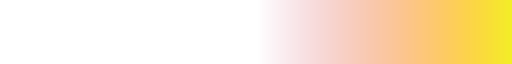

In [29]:
mycmap

In [30]:
marker = 'COL1'
imgs_col = []

# Read COL1 images
for donor in donors:
    path = p_dir / "data" / "whole_stitched"/ donor / f"{marker}.tif"
    
    img = skimage.io.imread(path)

    img_col= contrast_streching(img)
    if donor == 'INT Donor B':
        img_col = img_col[:5000, :]
    imgs_col.append(img_col)

    using data matrix X directly
Storing dendrogram info using `.uns['dendrogram_cluster_new']`
    using data matrix X directly
Storing dendrogram info using `.uns['dendrogram_cluster_new']`
    using data matrix X directly
Storing dendrogram info using `.uns['dendrogram_cluster_new']`
    using data matrix X directly
Storing dendrogram info using `.uns['dendrogram_cluster_new']`
    using data matrix X directly
Storing dendrogram info using `.uns['dendrogram_cluster_new']`
    using data matrix X directly
Storing dendrogram info using `.uns['dendrogram_cluster_new']`


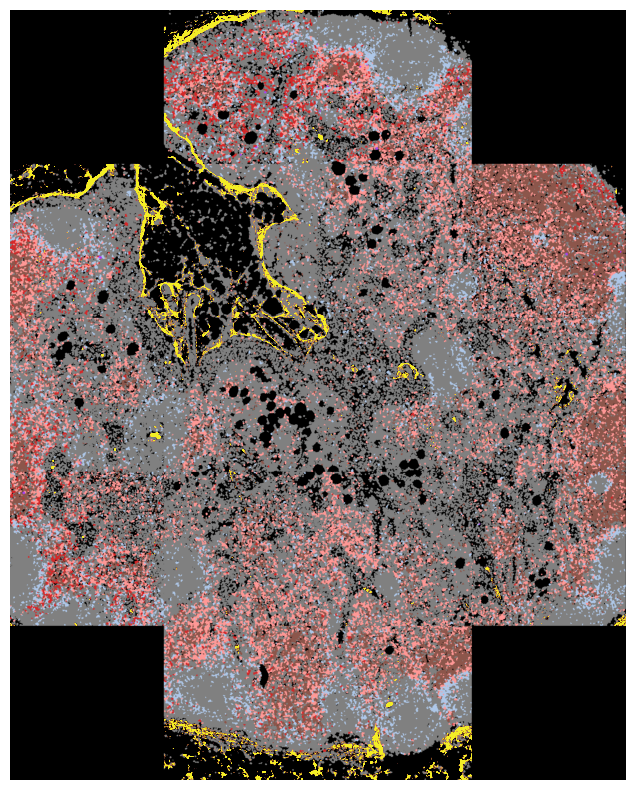

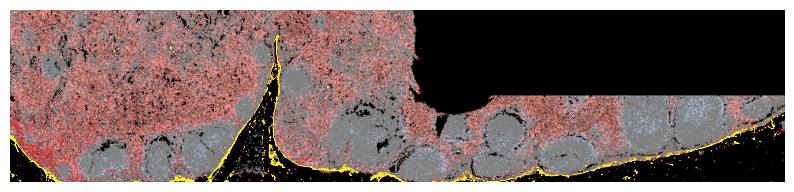

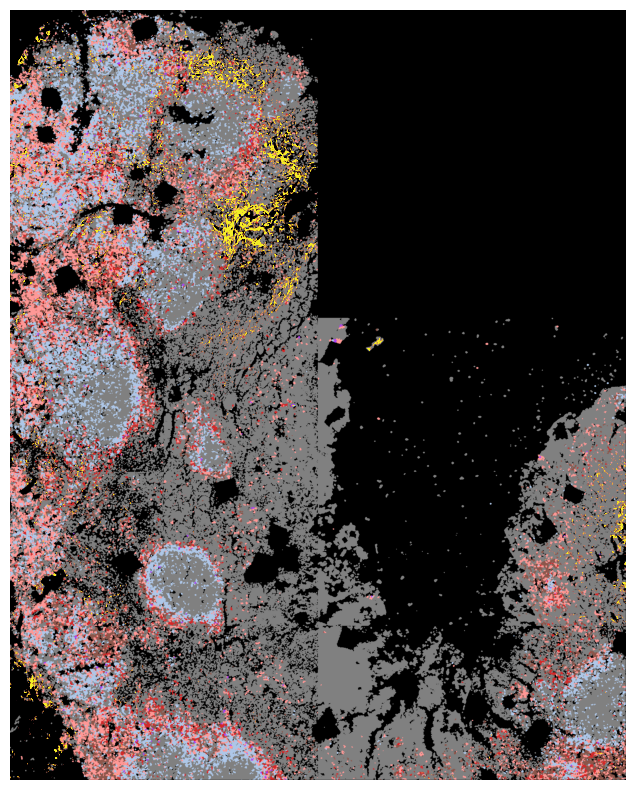

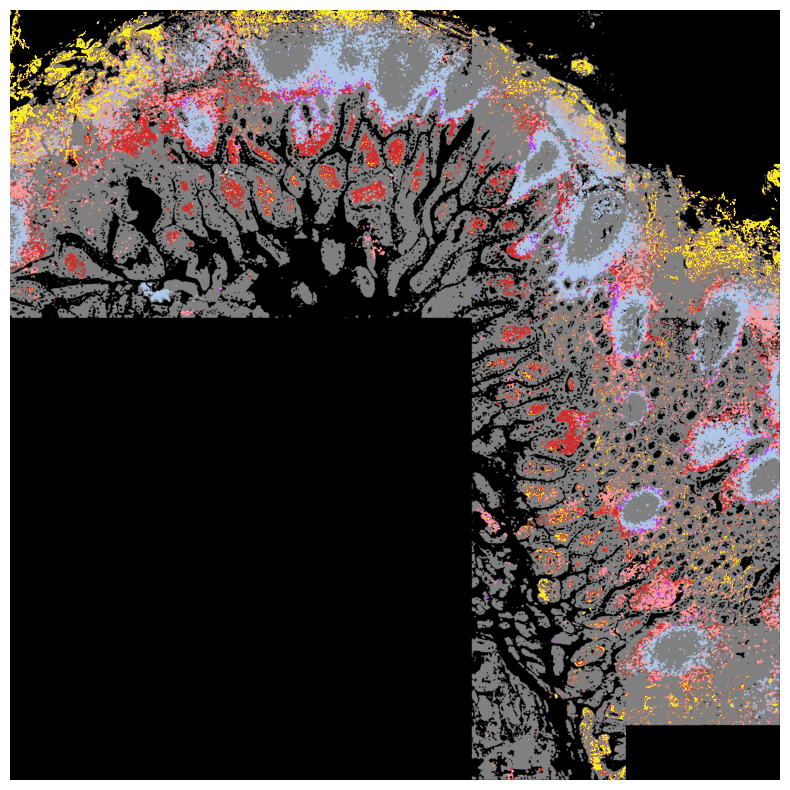

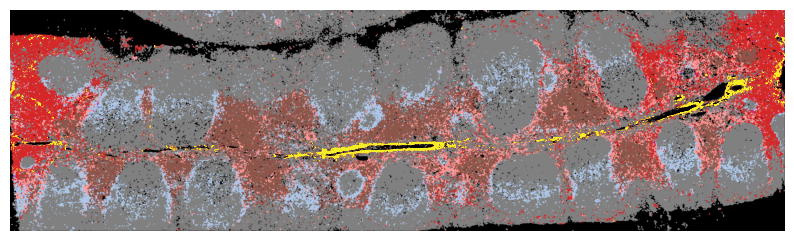

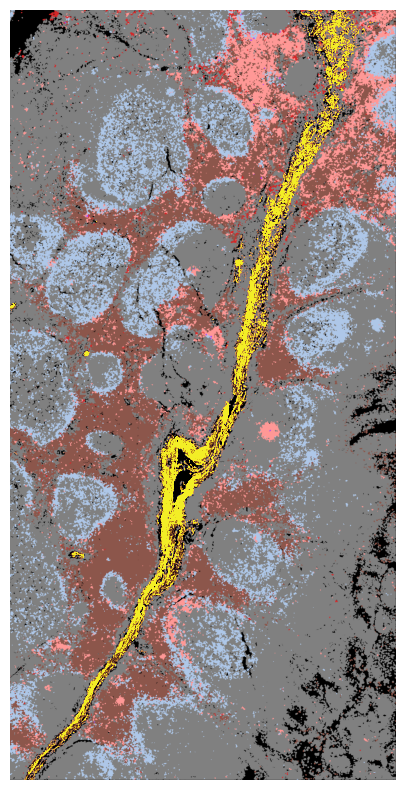

In [33]:
for i, donor in enumerate(donors):
    img_col = imgs_col[i]
# Get mask
    masks = get_masks(data_dir / "masks" / donor)

    # Get adata 
    phenotype_name = 'cluster_new'

    sc.tl.dendrogram(adata, groupby=phenotype_name)

    # Define colormap
    colors = adata.uns[f"{phenotype_name}_colors"]
    labels = adata.obs[phenotype_name].cat.categories.tolist()

    colors_rgb = []
    for color in colors:
        colors_rgb.append(matplotlib.colors.hex2color(color))
    colors_rgb = np.array(colors_rgb) * 255
    colors_rgb = colors_rgb.astype(np.uint8)
    colors_rgb_dict = {k:v for k,v in zip(labels, colors_rgb)}
    
    size = 1000 
    adata_donor = adata[adata.obs.Dataset == donor, :]

    # Create combined images
    y_max, x_max = get_img_size(arrangement[donor])
    img_combined = np.zeros((y_max, x_max, 3), dtype=np.uint8)

    # mask_grad = masks_grad[donors.index(donor)]

    for i in adata_donor.obs.ROI.unique():
        if i not in arrangement[donor].keys():
            continue

        # Get dataset
        adata_s = adata_donor[adata_donor.obs.ROI == i, :]
        mask = masks[str(int(i))]

        # Get label2cell dict
        label2cell = {}
        for j, l in enumerate(labels):
            cell_id = adata_s[adata_s.obs[phenotype_name] == l].obs.Cell.to_list()
            label2cell[j] = cell_id

        img = create_clustered_cell(mask, label2cell, colors_rgb)

        # Insert to combine image
        y = max(0, arrangement[donor][i][0] - 1)
        x = max(0, arrangement[donor][i][1] - 1)
        img_combined[y : y + size, x : x + size] = imgs
        
    fig, ax = plt.subplots(figsize=(10,10))
    ax.imshow(img_combined)
    ax.imshow(img_col, cmap=mycmap, alpha=1, vmax=150)
    ax.axis('off')
    fig.savefig(f'{donor}.png',bbox_inches='tight',transparent=True, pad_inches=0, dpi=450)